# Read raw continuous data from an SDS archive

https://docs.obspy.org/packages/autogen/obspy.clients.filesystem.sds.html#module-obspy.clients.filesystem.sds

In [1]:
import sys
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
import tools
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

# Show SDS_DIR
print('Tree listing of SDS_DIR directory')
for line in tools.tree(Path.cwd().joinpath(SDS_DIR)):
    print(line)

Tree listing of SDS_DIR directory
├── .DS_Store
├── 2009
│   └── AV
│       └── REF
│           └── EHZ.D
│               └── AV.REF..EHZ.D.2009.081
├── ._2009
└── 2003
    ├── .DS_Store
    └── MV
        ├── MBLG
        │   └── SHZ.D
        │       ├── MV.MBLG..SHZ.D.2003.194
        │       ├── MV.MBLG..SHZ.D.2003.193
        │       ├── MV.MBLG..SHZ.D.2003.192
        │       ├── MV.MBLG..SHZ.D.2003.195
        │       ├── MV.MBLG..SHZ.D.2003.197
        │       └── MV.MBLG..SHZ.D.2003.196
        ├── MBRY
        │   └── BHZ.D
        │       ├── MV.MBRY..BHZ.D.2003.195
        │       ├── MV.MBRY..BHZ.D.2003.192
        │       ├── MV.MBRY..BHZ.D.2003.193
        │       ├── MV.MBRY..BHZ.D.2003.194
        │       ├── MV.MBRY..BHZ.D.2003.196
        │       └── MV.MBRY..BHZ.D.2003.197
        ├── .DS_Store
        ├── MBWH
        │   └── SHZ.D
        │       ├── MV.MBWH..SHZ.D.2003.192
        │       ├── MV.MBWH..SHZ.D.2003.195
        │       ├── MV.MBWH..SHZ.D.2003.194
   

In [2]:
# Set start time
stime = obspy.UTCDateTime("2003196T")
print(stime)

# Get a list of NSLCs
print(sdsclient.get_all_nslc(datetime=stime))

2003-07-15T00:00:00.000000Z
[('MV', 'MBGB', '', 'BHZ'), ('MV', 'MBGH', '', 'BHZ'), ('MV', 'MBLG', '', 'SHZ'), ('MV', 'MBLY', '', 'BHZ'), ('MV', 'MBRV', '', 'SHZ'), ('MV', 'MBRY', '', 'BHZ'), ('MV', 'MBSS', '', 'SHZ'), ('MV', 'MBWH', '', 'SHZ')]


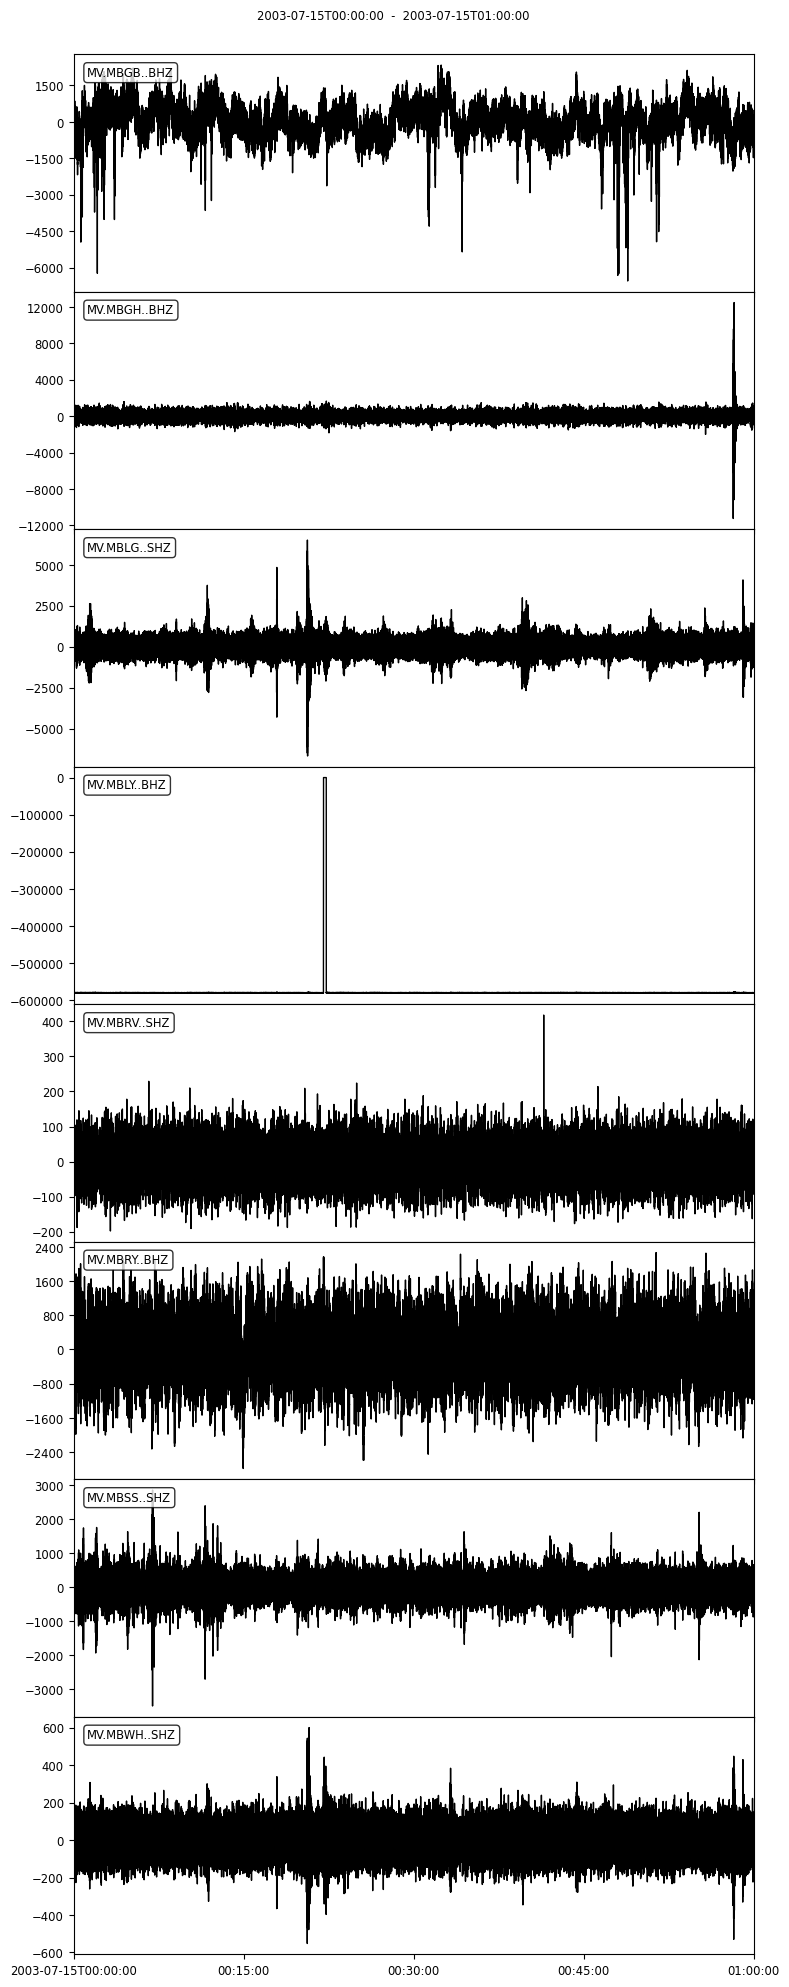

In [3]:
# Get and plot data
seconds = 3600
st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+seconds)
st.plot(equal_scale=False);

# Remove bad waveforms

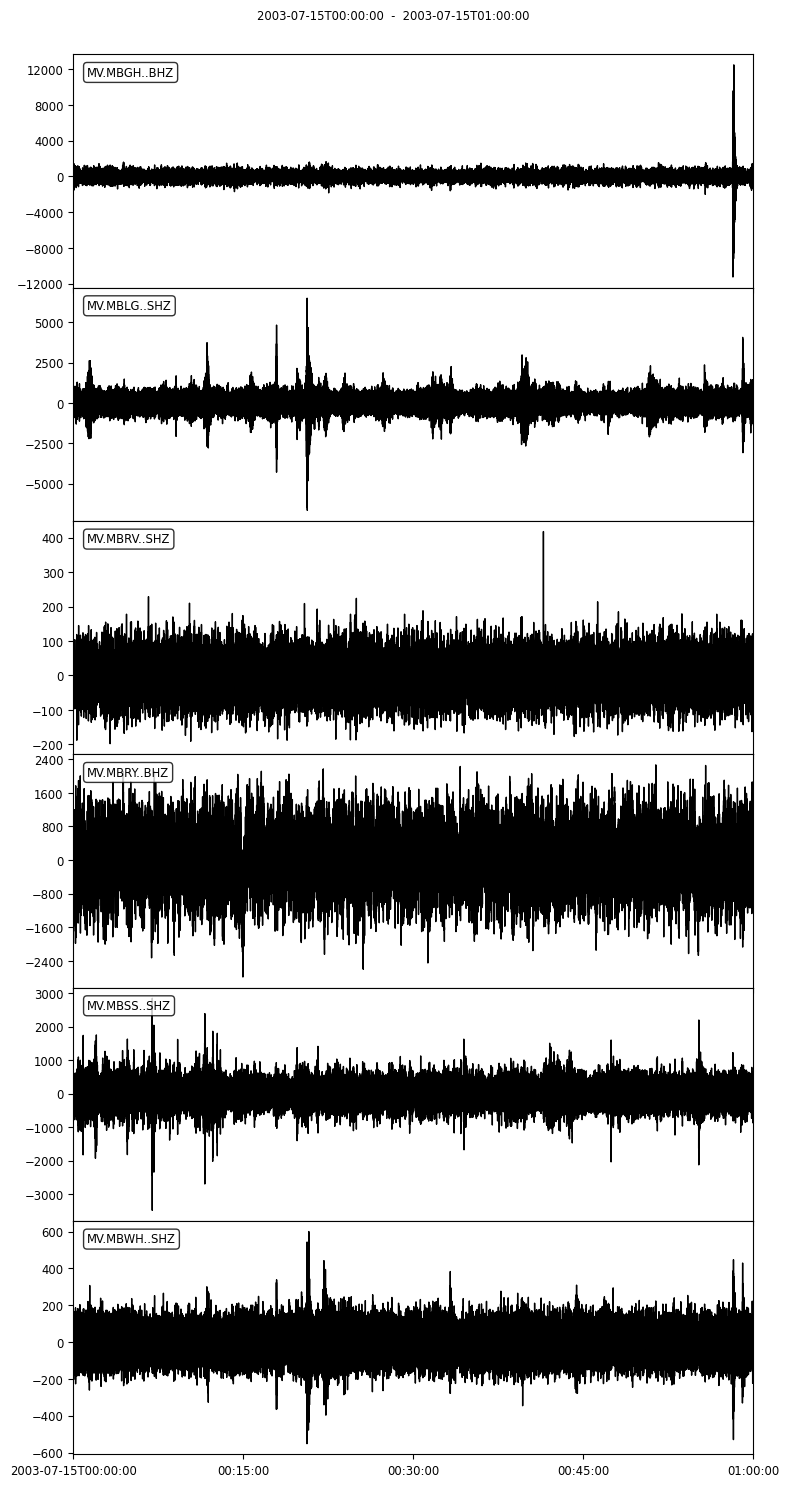

In [4]:
st.remove(st.select(id='MV.MBLY..BHZ')[0])
st.remove(st.select(id='MV.MBGB..BHZ')[0])
st.plot(equal_scale=False);

# Run STA/LTA Detector on a single channel

sampling_rate=75


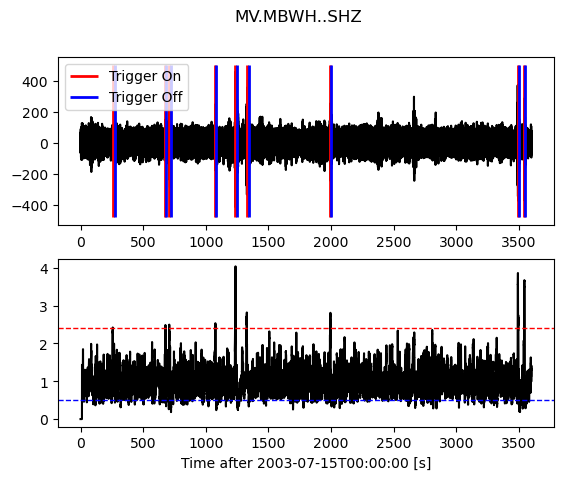

In [5]:
# Detection
import numpy as np
from obspy.signal.trigger import plot_trigger, classic_sta_lta, recursive_sta_lta

st2 = st.copy()

tr_index = -1

Fs = int(np.round(st[tr_index].stats.sampling_rate, 0))
print(f"sampling_rate={Fs}")

sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')
st2.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
sta_samples = int(sta_secs * Fs)
lta_samples = int(lta_secs * Fs)

#cft = recursive_sta_lta(st2[tr_index].data, sta_samples, lta_samples )
cft = classic_sta_lta(st2[tr_index].data, sta_samples, lta_samples )

plot_trigger(st2[tr_index], cft, threshON, threshOFF)

# Run STA/LTA on whole Stream object (network trigger)

In [8]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

threshStations = 3
max_secs = 120.0

#staltamethod = "recstalta"
#staltamethod = 'carlstatrig'
staltamethod = 'classicstalta'
trig = coincidence_trigger(staltamethod, threshON , threshOFF, st2, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)

for i, this_trig in enumerate(trig):
    print('\n',f'Event {i}')
    pprint(this_trig)


 Event 0
{'cft_peak_wmean': 3.4020313685287853,
 'cft_peaks': [3.726248396803897, 4.037324291649357, 2.4425214171331016],
 'cft_std_wmean': 0.8648763411928676,
 'cft_stds': [1.1219405483997342, 1.0121997758755752, 0.4604886993032938],
 'coincidence_sum': 3.0,
 'duration': 22.240000009536743,
 'similarity': {},
 'stations': ['MBLG', 'MBWH', 'MBGH'],
 'time': UTCDateTime(2003, 7, 15, 0, 20, 33, 240000),
 'trace_ids': ['MV.MBLG..SHZ', 'MV.MBWH..SHZ', 'MV.MBGH..BHZ']}

 Event 1
{'cft_peak_wmean': 2.798476102460846,
 'cft_peaks': [2.809065397902417, 2.95592845296121, 2.63043445651891],
 'cft_std_wmean': 0.700892754468299,
 'cft_stds': [0.7414515359968507, 0.7618267882010251, 0.5993999392070213],
 'coincidence_sum': 3.0,
 'duration': 10.653333306312561,
 'similarity': {},
 'stations': ['MBWH', 'MBGH', 'MBLG'],
 'time': UTCDateTime(2003, 7, 15, 0, 33, 13, 720000),
 'trace_ids': ['MV.MBWH..SHZ', 'MV.MBGH..BHZ', 'MV.MBLG..SHZ']}

 Event 2
{'cft_peak_wmean': 3.2602538574248863,
 'cft_peaks': [2

# Convert triggers to events and store in a (VolcanoSeismic)Catalog object

{'time': UTCDateTime(2003, 7, 15, 0, 20, 33, 240000), 'stations': ['MBLG', 'MBWH', 'MBGH'], 'trace_ids': ['MV.MBLG..SHZ', 'MV.MBWH..SHZ', 'MV.MBGH..BHZ'], 'coincidence_sum': 3.0, 'similarity': {}, 'cft_peaks': [3.726248396803897, 4.037324291649357, 2.4425214171331016], 'cft_stds': [1.1219405483997342, 1.0121997758755752, 0.4604886993032938], 'duration': 22.240000009536743, 'cft_peak_wmean': 3.4020313685287853, 'cft_std_wmean': 0.8648763411928676}
2003-07-15T00:20:33.240000Z
20
2003-07-15T00:20:13.240000Z
{'time': UTCDateTime(2003, 7, 15, 0, 33, 13, 720000), 'stations': ['MBWH', 'MBGH', 'MBLG'], 'trace_ids': ['MV.MBWH..SHZ', 'MV.MBGH..BHZ', 'MV.MBLG..SHZ'], 'coincidence_sum': 3.0, 'similarity': {}, 'cft_peaks': [2.809065397902417, 2.95592845296121, 2.63043445651891], 'cft_stds': [0.7414515359968507, 0.7618267882010251, 0.5993999392070213], 'duration': 10.653333306312561, 'cft_peak_wmean': 2.798476102460846, 'cft_std_wmean': 0.700892754468299}
2003-07-15T00:33:13.720000Z
20
2003-07-15T00

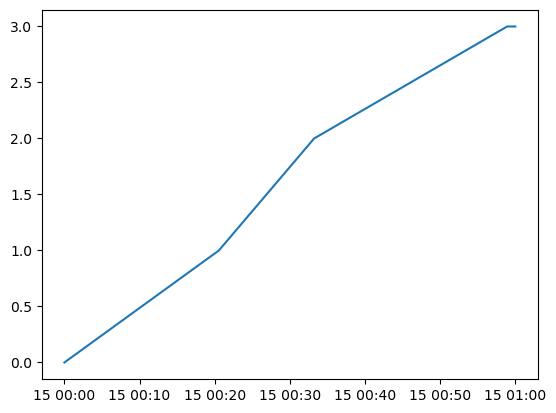

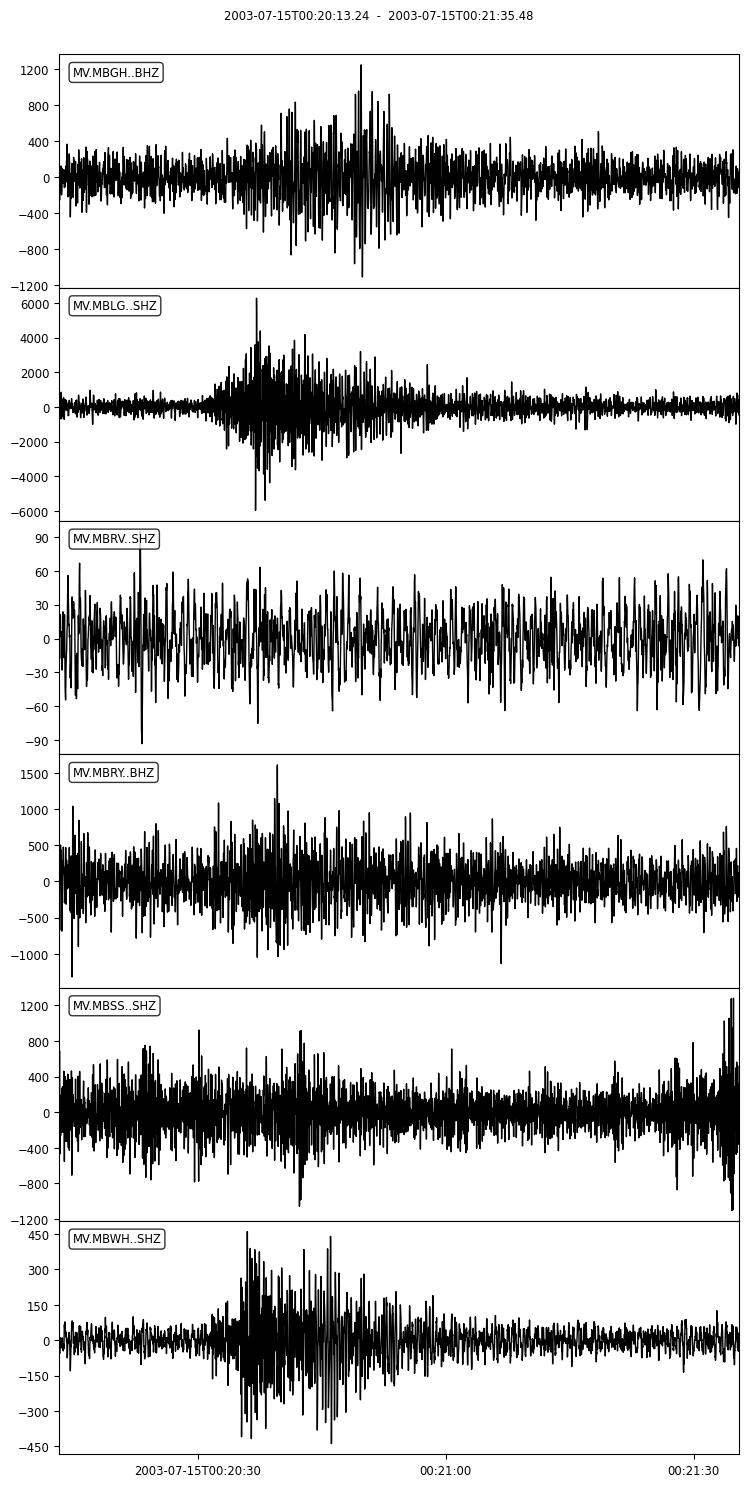


EVENT NUMBER:  2 time:  2003-07-15T00:32:53.720000Z 



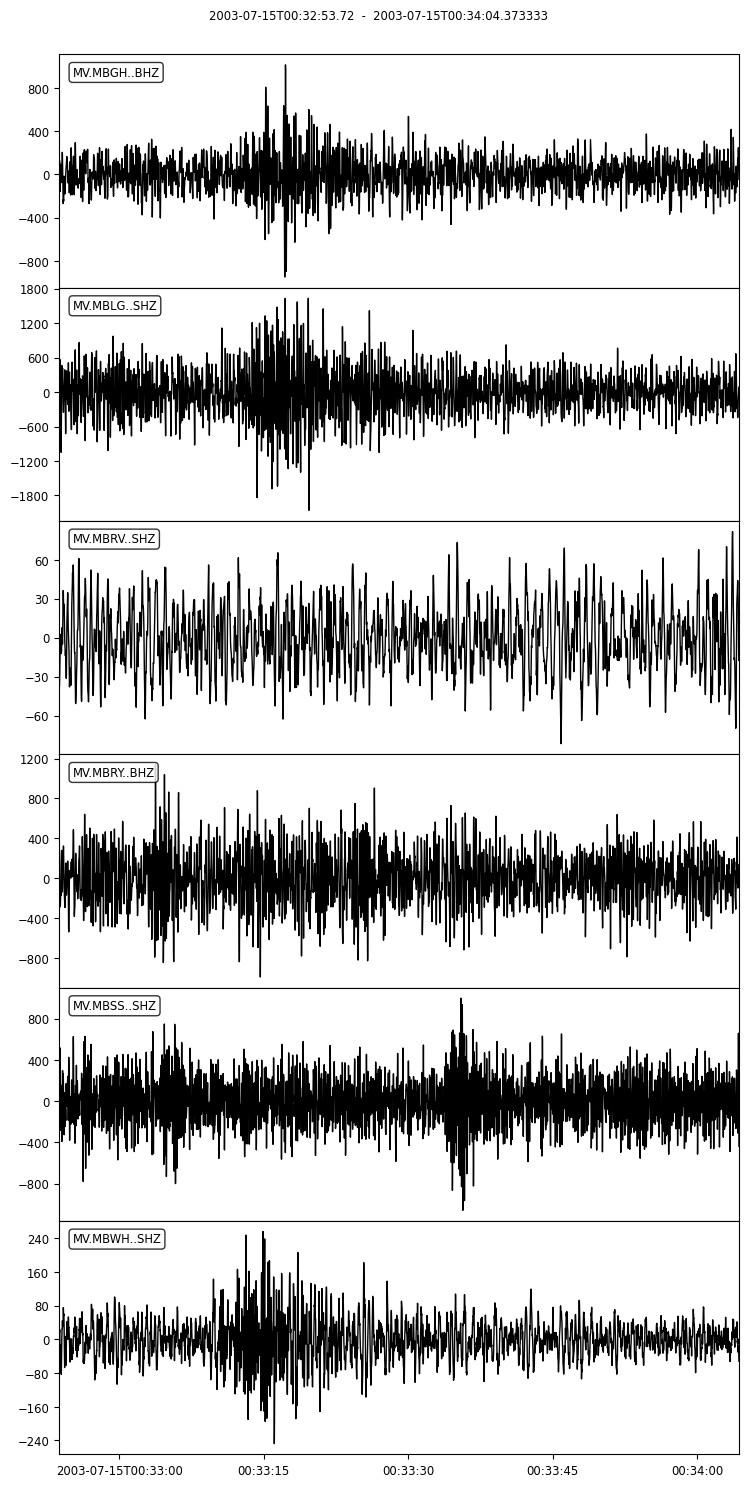


EVENT NUMBER:  3 time:  2003-07-15T00:58:34.880000Z 



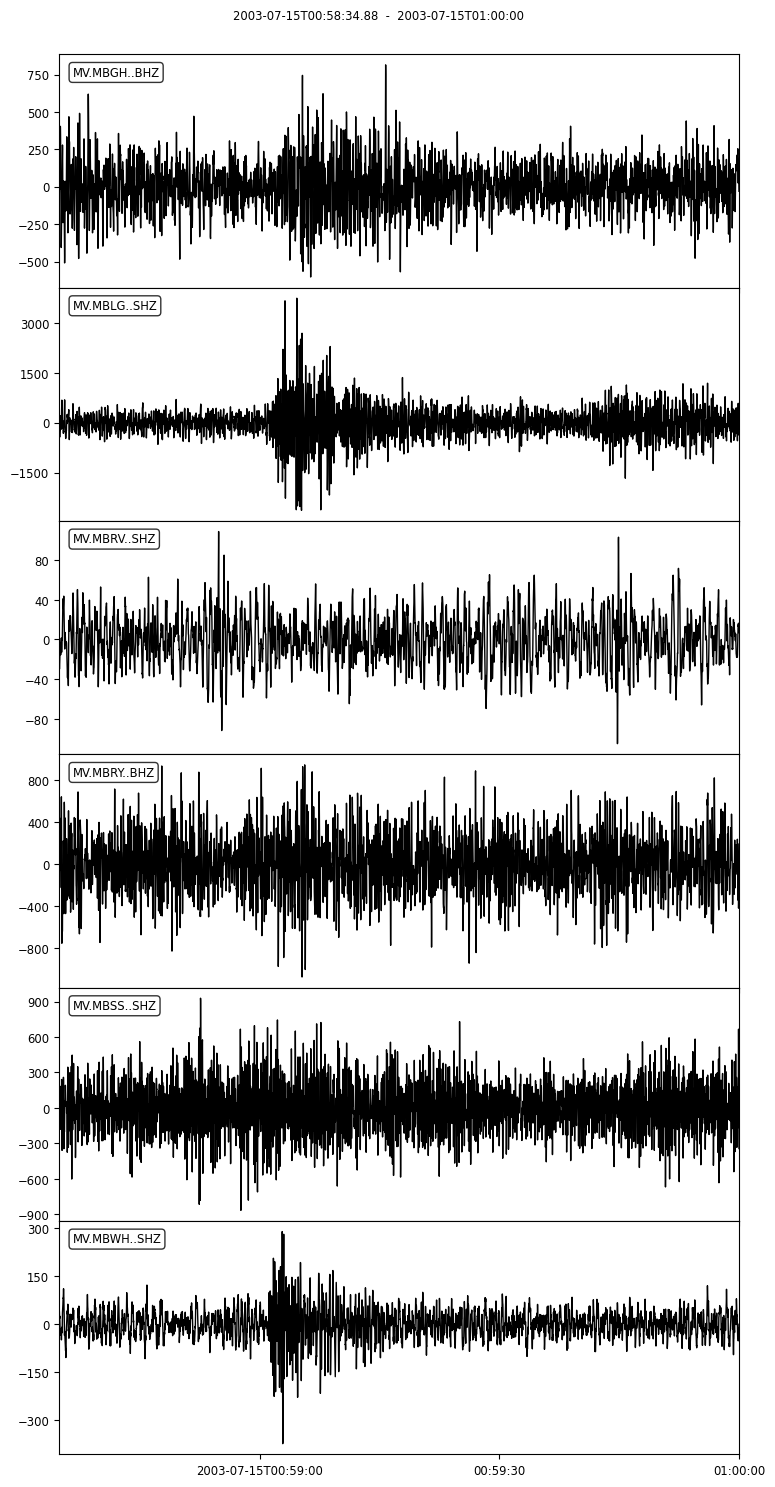

In [11]:
pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')
catalogObj = tools.triggers2volcanoseismiccatalog(trig, staltamethod, threshON, threshOFF, \
                                                  sta_secs, lta_secs, max_secs, stream=st2, pretrig=pretrig, posttrig=posttrig )
    
print(catalogObj)
dir(catalogObj)
#cat.get_times()
catalogObj.plot_eventrate()
catalogObj.plot_streams()
        

So we have the basic ability to detect events. Probably not very well. But then we could run it on multiple days of data and create a multi-day catalog. Then try running a simple event classifier on it, based on RSAM ratios or spectral metrics or full-blown ML features.

In [12]:
dir(catalogObj)

['__add__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getslice__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_creation_info',
 '_get_resource_id',
 '_repr_pretty_',
 '_set_creation_info',
 '_set_resource_id',
 'addEvent',
 'append',
 'clear',
 'comments',
 'copy',
 'count',
 'creation_info',
 'description',
 'endtime',
 'events',
 'extend',
 'filter',
 'get_times',
 'plot',
 'plot_eventrate',
 'plot_streams',
 'resource_id',
 'starttime',
 'streams',
 'triggerParams',
 'triggers',
 'write']

# Run coincidence trigger on multiple days, and append catalogs

In [ ]:
import sys
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
import tools
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

from obspy.signal.trigger import coincidence_trigger

# set parameters
seconds = 86400
threshStations = 3 # minimum number of stations that must trigger for a coincidence trigger to occur
max_secs = 120.0
staltamethod = 'classicstalta'
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')

pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   

catalog_all = None

for jday in range(192, 198, 1): # Loop over days in SDS archive

    # set start time
    stime = obspy.UTCDateTime(f"2003{jday}T")
    print(stime)

    # Get and plot data
    st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+seconds)

    # remove bad channels
    st.remove(st.select(id='MV.MBLY..BHZ')[0])
    st.remove(st.select(id='MV.MBGB..BHZ')[0])

    # bandpass filter
    st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)

    # run coincidence trigger for this day
    trig = coincidence_trigger(staltamethod, threshON , threshOFF, st, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)

    # create catalog object
    catalogObj = tools.triggers2volcanoseismiccatalog(trig, staltamethod, threshON, threshOFF, \
                                                  sta_secs, lta_secs, max_secs, stream=st, pretrig=pretrig, posttrig=posttrig )

    # concatenate catalogs
    if catalog_all:
        catalog_all.concat(catalogObj)
    else:
        catalog_all = catalogObj

print(catalog_all)
catalog_all.plot_eventrate()
catalog_all.write_events()



2003-07-11T00:00:00.000000Z
{'time': UTCDateTime(2003, 7, 11, 23, 40, 24, 226667), 'stations': ['MBWH', 'MBLG', 'MBGH', 'MBRY'], 'trace_ids': ['MV.MBWH..SHZ', 'MV.MBLG..SHZ', 'MV.MBGH..BHZ', 'MV.MBRY..BHZ'], 'coincidence_sum': 4.0, 'similarity': {}, 'cft_peaks': [4.412570170994267, 3.785886594454151, 3.5540738303601724, 2.500043165340581], 'cft_stds': [1.1455451236975522, 0.9779173877994556, 0.990135500844446, 0.6740485959289712], 'duration': 15.333333373069763, 'cft_peak_wmean': 3.563143440287293, 'cft_std_wmean': 0.9469116520676062}
2003-07-11T23:40:24.226667Z
20
2003-07-11T23:40:04.226667Z
{'time': UTCDateTime(2003, 7, 11, 23, 41, 4, 400000), 'stations': ['MBWH', 'MBLG', 'MBRY', 'MBGH'], 'trace_ids': ['MV.MBWH..SHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBGH..BHZ'], 'coincidence_sum': 4.0, 'similarity': {}, 'cft_peaks': [4.47349871961924, 4.042682968019467, 3.3380781179507144, 3.5461959247450467], 'cft_stds': [1.1461169557972588, 1.0542566317802053, 0.9869651339842083, 0.886733560044